In [1]:
import pandas as pd
import sys
sys.path.append("..")
from src.Eval import eval_llm

import os
import io
from contextlib import redirect_stdout


In [2]:
import sys
sys.path.append("..")
from src.Eval import eval_llm

import os
import io
from contextlib import redirect_stdout

def clean_dict(d):
    """
    Recursively remove keys from a dictionary if they map to empty lists.
    """
    if isinstance(d, dict):
        return {k: clean_dict(v) for k, v in d.items() if clean_dict(v) != {} and v != []}
    elif isinstance(d, list):
        return [clean_dict(item) for item in d if clean_dict(item) != {} and item != []]
    else:
        return d

def parse_filename(filename):
    parts = filename.replace(".jsonl", "").split("_")
    dataset = parts[0]
    k_shot = parts[1].split(".")[0]
    k = int(k_shot.replace("shot", ""))
    if k and k != 0 and len(parts) == 3:
        sampling_method = parts[2]
    else:
        sampling_method = "rand"
    return dataset, k, sampling_method

def silent_eval_llm(fpath):
    with io.StringIO() as buf, redirect_stdout(buf):
        # Call the actual eval_llm function
        return eval_llm(fpath)
    
def aggregated_results_llm(
    results_dir,
    ent_types=["overall", "Artist", "WoA"],
    eval_schemas=["strict", "exact", "ent_type"],
    metrics=["f1", "f1_macro", "f1_micro", "precision", "precision_macro", "recall", "recall_macro", "missed", "spurious", "incorrect"],
    datasets=["dataset1", "dataset2", "dataset3", "dataset4", "dataset5"],
    sampling_methods=["rand", "tfidf", ""],
    ks=[0,5,15,25,35,45]
):
    results = {}
    for schema in eval_schemas:
        results[schema] = {}
        for ent_type in ent_types:
            results[schema][ent_type] = {}
            for metric in metrics:
                results[schema][ent_type][metric] = {}
                for model in [m for m in os.listdir(results_dir) if m != "archive"]:
                    results[schema][ent_type][metric][model] = {}
                    for sampling_method in sampling_methods:
                        results[schema][ent_type][metric][model][sampling_method] = {}
                        for k in ks:
                            results[schema][ent_type][metric][model][sampling_method][k] = []

    model_dirs = [
        os.path.join(results_dir, d)
        for d in os.listdir(results_dir)
        if os.path.isdir(os.path.join(results_dir, d)) and d != "archive"
    ]

    for model_dir in model_dirs:
        model = model_dir.split(os.sep)[-1]
        files = [
            os.path.join(model_dir, f)
            for f in os.listdir(model_dir)
            if os.path.isfile(os.path.join(model_dir, f))
        ]

        for fpath in files:
            print(fpath)
            filename = os.path.basename(fpath)
            dataset, k, sampling_method = parse_filename(filename)

            if dataset in datasets and k in ks:
                predictions = silent_eval_llm(fpath)

                for ent_type in ent_types:
                    for schema in eval_schemas:
                        for metric in metrics:
                            key = f"{ent_type}_{schema}_{metric}"
                            if key in predictions.keys():
                                results[schema][ent_type][metric][model][sampling_method][k].append(predictions[key])
                                if k == 0:
                                    for other_sampling_method in [s for s in sampling_methods if s != sampling_method]:
                                        results[schema][ent_type][metric][model][other_sampling_method][k].append(predictions[key])
    return clean_dict(results)

results = aggregated_results_llm("../output/reddit+shsyt/")
#results_tfidf = aggregated_results_llm("../output/tfidf_sampling")


2024-09-11 15:13:39 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset2_5shot_tfidf.jsonl


2024-09-11 15:13:40 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset4_35shot_tfidf.jsonl
../output/reddit+shsyt/llama3.1:70b/dataset2_15shot_tfidf.jsonl


2024-09-11 15:13:40 root INFO: Imported 660 predictions for 660 true examples
2024-09-11 15:13:40 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset1_25shot_tfidf.jsonl


2024-09-11 15:13:40 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset3_5shot_tfidf.jsonl


2024-09-11 15:13:41 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset5_5shot_tfidf.jsonl


2024-09-11 15:13:41 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset2_35shot_rand.jsonl


2024-09-11 15:13:41 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset5_15shot_rand.jsonl


2024-09-11 15:13:41 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset4_25shot_tfidf.jsonl


2024-09-11 15:13:41 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset5_5shot_rand.jsonl


2024-09-11 15:13:42 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset5_35shot_tfidf.jsonl


2024-09-11 15:13:42 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset1_35shot_rand.jsonl


2024-09-11 15:13:42 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset4_0shot.jsonl


2024-09-11 15:13:42 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset1_0shot.jsonl


2024-09-11 15:13:43 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset5_0shot.jsonl


2024-09-11 15:13:43 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset3_15shot_tfidf.jsonl


2024-09-11 15:13:43 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset2_25shot_rand.jsonl


2024-09-11 15:13:43 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset3_25shot_tfidf.jsonl


2024-09-11 15:13:44 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset2_5shot_rand.jsonl


2024-09-11 15:13:44 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset1_15shot_tfidf.jsonl


2024-09-11 15:13:44 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset2_15shot_rand.jsonl


2024-09-11 15:13:44 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset5_35shot_rand.jsonl


2024-09-11 15:13:45 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset5_15shot_tfidf.jsonl


2024-09-11 15:13:45 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset1_5shot_tfidf.jsonl


2024-09-11 15:13:45 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset1_15shot_rand.jsonl


2024-09-11 15:13:45 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset4_35shot_rand.jsonl


2024-09-11 15:13:45 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset4_25shot_rand.jsonl


2024-09-11 15:13:46 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset3_0shot.jsonl


2024-09-11 15:13:46 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset3_35shot_tfidf.jsonl


2024-09-11 15:13:46 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset2_0shot.jsonl


2024-09-11 15:13:46 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset5_25shot_rand.jsonl
../output/reddit+shsyt/llama3.1:70b/dataset3_5shot_rand.jsonl


2024-09-11 15:13:47 root INFO: Imported 658 predictions for 658 true examples
2024-09-11 15:13:47 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset1_5shot_rand.jsonl


2024-09-11 15:13:47 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset4_15shot_tfidf.jsonl


2024-09-11 15:13:47 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset3_25shot_rand.jsonl


2024-09-11 15:13:48 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset1_35shot_tfidf.jsonl


2024-09-11 15:13:48 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset1_25shot_rand.jsonl


2024-09-11 15:13:48 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset3_15shot_rand.jsonl


2024-09-11 15:13:48 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset2_35shot_tfidf.jsonl


2024-09-11 15:13:48 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset4_5shot_tfidf.jsonl


2024-09-11 15:13:49 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset4_15shot_rand.jsonl


2024-09-11 15:13:49 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset4_5shot_rand.jsonl


2024-09-11 15:13:49 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset3_35shot_rand.jsonl


2024-09-11 15:13:49 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/llama3.1:70b/dataset5_25shot_tfidf.jsonl


2024-09-11 15:13:50 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/llama3.1:70b/dataset2_25shot_tfidf.jsonl


2024-09-11 15:13:50 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/firefunction-v2/dataset2_5shot_tfidf.jsonl


2024-09-11 15:13:50 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset4_35shot_tfidf.jsonl
../output/reddit+shsyt/firefunction-v2/dataset2_15shot_tfidf.jsonl


2024-09-11 15:13:50 root INFO: Imported 660 predictions for 660 true examples
2024-09-11 15:13:50 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/firefunction-v2/dataset1_25shot_tfidf.jsonl


2024-09-11 15:13:51 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset3_5shot_tfidf.jsonl
../output/reddit+shsyt/firefunction-v2/dataset5_5shot_tfidf.jsonl


2024-09-11 15:13:51 root INFO: Imported 658 predictions for 658 true examples
2024-09-11 15:13:51 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/firefunction-v2/dataset2_35shot_rand.jsonl


2024-09-11 15:13:51 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset5_15shot_rand.jsonl


2024-09-11 15:13:52 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset4_25shot_tfidf.jsonl
../output/reddit+shsyt/firefunction-v2/dataset5_5shot_rand.jsonl


2024-09-11 15:13:52 root INFO: Imported 658 predictions for 658 true examples
2024-09-11 15:13:52 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset5_35shot_tfidf.jsonl


2024-09-11 15:13:52 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/firefunction-v2/dataset1_35shot_rand.jsonl


2024-09-11 15:13:52 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset4_0shot.jsonl
../output/reddit+shsyt/firefunction-v2/dataset1_0shot.jsonl


2024-09-11 15:13:53 root INFO: Imported 660 predictions for 660 true examples
2024-09-11 15:13:53 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset5_0shot.jsonl


2024-09-11 15:13:53 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset3_15shot_tfidf.jsonl
../output/reddit+shsyt/firefunction-v2/dataset2_25shot_rand.jsonl


2024-09-11 15:13:53 root INFO: Imported 660 predictions for 660 true examples
2024-09-11 15:13:53 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset3_25shot_tfidf.jsonl
../output/reddit+shsyt/firefunction-v2/dataset2_5shot_rand.jsonl


2024-09-11 15:13:54 root INFO: Imported 660 predictions for 660 true examples
2024-09-11 15:13:54 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/firefunction-v2/dataset1_15shot_tfidf.jsonl


2024-09-11 15:13:54 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/firefunction-v2/dataset2_15shot_rand.jsonl
../output/reddit+shsyt/firefunction-v2/dataset5_35shot_rand.jsonl


2024-09-11 15:13:54 root INFO: Imported 658 predictions for 658 true examples
2024-09-11 15:13:55 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset5_15shot_tfidf.jsonl


2024-09-11 15:13:55 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/firefunction-v2/dataset1_5shot_tfidf.jsonl


2024-09-11 15:13:55 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/firefunction-v2/dataset1_15shot_rand.jsonl


2024-09-11 15:13:55 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset4_35shot_rand.jsonl
../output/reddit+shsyt/firefunction-v2/dataset4_25shot_rand.jsonl


2024-09-11 15:13:55 root INFO: Imported 658 predictions for 658 true examples
2024-09-11 15:13:56 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset3_0shot.jsonl
../output/reddit+shsyt/firefunction-v2/dataset3_35shot_tfidf.jsonl


2024-09-11 15:13:56 root INFO: Imported 658 predictions for 658 true examples
2024-09-11 15:13:56 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/firefunction-v2/dataset2_0shot.jsonl


2024-09-11 15:13:56 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset5_25shot_rand.jsonl
../output/reddit+shsyt/firefunction-v2/dataset3_5shot_rand.jsonl


2024-09-11 15:13:57 root INFO: Imported 658 predictions for 658 true examples
2024-09-11 15:13:57 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/firefunction-v2/dataset1_5shot_rand.jsonl


2024-09-11 15:13:57 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset4_15shot_tfidf.jsonl


2024-09-11 15:13:57 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset3_25shot_rand.jsonl
../output/reddit+shsyt/firefunction-v2/dataset1_35shot_tfidf.jsonl


2024-09-11 15:13:57 root INFO: Imported 660 predictions for 660 true examples
2024-09-11 15:13:58 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/firefunction-v2/dataset1_25shot_rand.jsonl


2024-09-11 15:13:58 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset3_15shot_rand.jsonl
../output/reddit+shsyt/firefunction-v2/dataset2_35shot_tfidf.jsonl


2024-09-11 15:13:58 root INFO: Imported 660 predictions for 660 true examples
2024-09-11 15:13:58 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset4_5shot_tfidf.jsonl


2024-09-11 15:13:58 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset4_15shot_rand.jsonl


2024-09-11 15:13:59 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset4_5shot_rand.jsonl


2024-09-11 15:13:59 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/firefunction-v2/dataset3_35shot_rand.jsonl
../output/reddit+shsyt/firefunction-v2/dataset5_25shot_tfidf.jsonl


2024-09-11 15:13:59 root INFO: Imported 658 predictions for 658 true examples
2024-09-11 15:13:59 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/firefunction-v2/dataset2_25shot_tfidf.jsonl


2024-09-11 15:14:00 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/gpt-4o-mini/dataset1_0shot.jsonl


2024-09-11 15:14:00 root INFO: Imported 42 predictions for 42 true examples
2024-09-11 15:14:00 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/gpt-4o-mini/dataset1_5shot_tfidf.jsonl
../output/reddit+shsyt/gpt-4o-mini/dataset1_5shot_rand.jsonl


2024-09-11 15:14:00 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset2_5shot_tfidf.jsonl
../output/reddit+shsyt/mixtral:8x22b/dataset4_35shot_tfidf.jsonl


2024-09-11 15:14:00 root INFO: Imported 658 predictions for 658 true examples
2024-09-11 15:14:01 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset2_15shot_tfidf.jsonl


2024-09-11 15:14:01 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset1_25shot_tfidf.jsonl


2024-09-11 15:14:01 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset3_5shot_tfidf.jsonl


2024-09-11 15:14:01 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset5_5shot_tfidf.jsonl


2024-09-11 15:14:01 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset2_35shot_rand.jsonl


2024-09-11 15:14:02 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset5_15shot_rand.jsonl


2024-09-11 15:14:02 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset4_25shot_tfidf.jsonl


2024-09-11 15:14:02 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset5_5shot_rand.jsonl


2024-09-11 15:14:02 root INFO: Imported 0 predictions for 0 true examples
2024-09-11 15:14:02 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset5_35shot_tfidf.jsonl
../output/reddit+shsyt/mixtral:8x22b/dataset1_35shot_rand.jsonl


2024-09-11 15:14:03 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset4_0shot.jsonl


2024-09-11 15:14:03 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset1_0shot.jsonl


2024-09-11 15:14:03 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset5_0shot.jsonl


2024-09-11 15:14:03 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset3_15shot_tfidf.jsonl


2024-09-11 15:14:04 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset2_25shot_rand.jsonl


2024-09-11 15:14:04 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset3_25shot_tfidf.jsonl


2024-09-11 15:14:04 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset2_5shot_rand.jsonl


2024-09-11 15:14:04 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset1_15shot_tfidf.jsonl


2024-09-11 15:14:04 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset2_15shot_rand.jsonl


2024-09-11 15:14:05 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset5_35shot_rand.jsonl


2024-09-11 15:14:05 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset5_15shot_tfidf.jsonl


2024-09-11 15:14:05 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset1_5shot_tfidf.jsonl


2024-09-11 15:14:05 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset1_15shot_rand.jsonl


2024-09-11 15:14:06 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset4_35shot_rand.jsonl


2024-09-11 15:14:06 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset4_25shot_rand.jsonl


2024-09-11 15:14:06 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset3_0shot.jsonl


2024-09-11 15:14:06 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset3_35shot_tfidf.jsonl


2024-09-11 15:14:06 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset2_0shot.jsonl


2024-09-11 15:14:07 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset5_25shot_rand.jsonl


2024-09-11 15:14:07 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset3_5shot_rand.jsonl


2024-09-11 15:14:07 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset1_5shot_rand.jsonl


2024-09-11 15:14:07 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset4_15shot_tfidf.jsonl


2024-09-11 15:14:08 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset3_25shot_rand.jsonl


2024-09-11 15:14:08 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset1_35shot_tfidf.jsonl


2024-09-11 15:14:08 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset1_25shot_rand.jsonl


2024-09-11 15:14:08 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset3_15shot_rand.jsonl


2024-09-11 15:14:08 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset2_35shot_tfidf.jsonl


2024-09-11 15:14:09 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset4_5shot_tfidf.jsonl


2024-09-11 15:14:09 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset4_15shot_rand.jsonl
../output/reddit+shsyt/mixtral:8x22b/dataset4_5shot_rand.jsonl


2024-09-11 15:14:09 root INFO: Imported 658 predictions for 658 true examples
2024-09-11 15:14:10 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset3_35shot_rand.jsonl


2024-09-11 15:14:10 root INFO: Imported 658 predictions for 658 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset5_25shot_tfidf.jsonl


2024-09-11 15:14:10 root INFO: Imported 660 predictions for 660 true examples


../output/reddit+shsyt/mixtral:8x22b/dataset2_25shot_tfidf.jsonl


In [12]:
eval_llm("../output/reddit+shsyt_cloze/firefunction-v2/post_cutoff/firefunction-v2/dataset1_0shot.jsonl")


2024-09-11 15:25:21 root INFO: Imported 529 predictions for 529 true examples


Input path: ../output/reddit+shsyt_cloze/firefunction-v2/post_cutoff/firefunction-v2/dataset1_0shot.jsonl

 Overall
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.524217  0.317241  0.395274        368          205          0       587         129        1160       702
ent_type     0.589744  0.356897  0.444683        414          159          0       587         129        1160       702
exact        0.750712  0.45431   0.566058        527           46          0       587         129        1160       702

 Artist
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.478495  0.291

{'overall_strict_precision_micro': 0.5242165242165242,
 'overall_strict_recall_micro': 0.31724137931034485,
 'overall_strict_f1_micro': 0.39527389903329757,
 'overall_strict_correct_micro': 368,
 'overall_strict_incorrect_micro': 205,
 'overall_strict_partial_micro': 0,
 'overall_strict_missed_micro': 587,
 'overall_strict_spurious_micro': 129,
 'overall_strict_possible_micro': 1160,
 'overall_strict_actual_micro': 702,
 'overall_ent_type_precision_micro': 0.5897435897435898,
 'overall_ent_type_recall_micro': 0.3568965517241379,
 'overall_ent_type_f1_micro': 0.4446831364124597,
 'overall_ent_type_correct_micro': 414,
 'overall_ent_type_incorrect_micro': 159,
 'overall_ent_type_partial_micro': 0,
 'overall_ent_type_missed_micro': 587,
 'overall_ent_type_spurious_micro': 129,
 'overall_ent_type_possible_micro': 1160,
 'overall_ent_type_actual_micro': 702,
 'overall_exact_precision_micro': 0.7507122507122507,
 'overall_exact_recall_micro': 0.4543103448275862,
 'overall_exact_f1_micro': 0.

In [13]:
eval_llm("../output/reddit+shsyt_cloze/firefunction-v2/post_cutoff/firefunction-v2/dataset1_35shot_tfidf.jsonl")


2024-09-11 15:25:47 root INFO: Imported 529 predictions for 529 true examples


Input path: ../output/reddit+shsyt_cloze/firefunction-v2/post_cutoff/firefunction-v2/dataset1_35shot_tfidf.jsonl

 Overall
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.603314  0.533621  0.566331        619          232          0       309         175        1160      1026
ent_type     0.678363  0.6       0.63678         696          155          0       309         175        1160      1026
exact        0.754386  0.667241  0.708143        774           77          0       309         175        1160      1026

 Artist
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.620626

{'overall_strict_precision_micro': 0.6033138401559455,
 'overall_strict_recall_micro': 0.5336206896551724,
 'overall_strict_f1_micro': 0.5663311985361391,
 'overall_strict_correct_micro': 619,
 'overall_strict_incorrect_micro': 232,
 'overall_strict_partial_micro': 0,
 'overall_strict_missed_micro': 309,
 'overall_strict_spurious_micro': 175,
 'overall_strict_possible_micro': 1160,
 'overall_strict_actual_micro': 1026,
 'overall_ent_type_precision_micro': 0.6783625730994152,
 'overall_ent_type_recall_micro': 0.6,
 'overall_ent_type_f1_micro': 0.6367795059469351,
 'overall_ent_type_correct_micro': 696,
 'overall_ent_type_incorrect_micro': 155,
 'overall_ent_type_partial_micro': 0,
 'overall_ent_type_missed_micro': 309,
 'overall_ent_type_spurious_micro': 175,
 'overall_ent_type_possible_micro': 1160,
 'overall_ent_type_actual_micro': 1026,
 'overall_exact_precision_micro': 0.7543859649122807,
 'overall_exact_recall_micro': 0.6672413793103448,
 'overall_exact_f1_micro': 0.708142726440988

In [14]:
eval_llm("../output/reddit+shsyt_cloze/firefunction-v2/post_cutoff/firefunction-v2/dataset1_35shot_rand.jsonl")


Input path: ../output/reddit+shsyt_cloze/firefunction-v2/post_cutoff/firefunction-v2/dataset1_35shot_rand.jsonl


2024-09-11 15:26:12 root INFO: Imported 529 predictions for 529 true examples



 Overall
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.56979   0.513793  0.540345        596          259          0       305         191        1160      1046
ent_type     0.640535  0.577586  0.607434        670          185          0       305         191        1160      1046
exact        0.746654  0.673276  0.708069        781           74          0       305         191        1160      1046

 Artist
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.571691  0.509836  0.538995        311          157          0       142          76         610       544
ent_type     

{'overall_strict_precision_micro': 0.5697896749521989,
 'overall_strict_recall_micro': 0.5137931034482759,
 'overall_strict_f1_micro': 0.5403445149592022,
 'overall_strict_correct_micro': 596,
 'overall_strict_incorrect_micro': 259,
 'overall_strict_partial_micro': 0,
 'overall_strict_missed_micro': 305,
 'overall_strict_spurious_micro': 191,
 'overall_strict_possible_micro': 1160,
 'overall_strict_actual_micro': 1046,
 'overall_ent_type_precision_micro': 0.6405353728489483,
 'overall_ent_type_recall_micro': 0.5775862068965517,
 'overall_ent_type_f1_micro': 0.6074342701722574,
 'overall_ent_type_correct_micro': 670,
 'overall_ent_type_incorrect_micro': 185,
 'overall_ent_type_partial_micro': 0,
 'overall_ent_type_missed_micro': 305,
 'overall_ent_type_spurious_micro': 191,
 'overall_ent_type_possible_micro': 1160,
 'overall_ent_type_actual_micro': 1046,
 'overall_exact_precision_micro': 0.7466539196940727,
 'overall_exact_recall_micro': 0.6732758620689655,
 'overall_exact_f1_micro': 0.

In [15]:
eval_llm("../output/reddit+shsyt_cloze/firefunction-v2/seen/firefunction-v2/dataset1_35shot_rand.jsonl")


Input path: ../output/reddit+shsyt_cloze/firefunction-v2/seen/firefunction-v2/dataset1_35shot_rand.jsonl


2024-09-11 15:26:57 root INFO: Imported 529 predictions for 529 true examples



 Overall
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.798932  0.793286  0.796099        898          115          0       119         111        1132      1124
ent_type     0.869217  0.863074  0.866135        977           36          0       119         111        1132      1124
exact        0.830961  0.825088  0.828014        934           79          0       119         111        1132      1124

 Artist
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.805556  0.78254   0.793881        493           73          0        64          46         630       612
ent_type     

{'overall_strict_precision_micro': 0.798932384341637,
 'overall_strict_recall_micro': 0.7932862190812721,
 'overall_strict_f1_micro': 0.7960992907801419,
 'overall_strict_correct_micro': 898,
 'overall_strict_incorrect_micro': 115,
 'overall_strict_partial_micro': 0,
 'overall_strict_missed_micro': 119,
 'overall_strict_spurious_micro': 111,
 'overall_strict_possible_micro': 1132,
 'overall_strict_actual_micro': 1124,
 'overall_ent_type_precision_micro': 0.8692170818505338,
 'overall_ent_type_recall_micro': 0.8630742049469965,
 'overall_ent_type_f1_micro': 0.8661347517730497,
 'overall_ent_type_correct_micro': 977,
 'overall_ent_type_incorrect_micro': 36,
 'overall_ent_type_partial_micro': 0,
 'overall_ent_type_missed_micro': 119,
 'overall_ent_type_spurious_micro': 111,
 'overall_ent_type_possible_micro': 1132,
 'overall_ent_type_actual_micro': 1124,
 'overall_exact_precision_micro': 0.8309608540925267,
 'overall_exact_recall_micro': 0.8250883392226148,
 'overall_exact_f1_micro': 0.82

In [3]:
import pandas as pd
import numpy as np

def results_to_dataframe(aggregated_results, agg_func='mean'):
    data = []

    for schema, schema_dict in aggregated_results.items():
        for ent_type, ent_type_dict in schema_dict.items():
            for metric, metric_dict in ent_type_dict.items():
                for model, model_dict in metric_dict.items():
                    for sampling, sampling_dict in model_dict.items():
                        for k_shot, values in sampling_dict.items():
                            if values:
                                if agg_func == 'mean':
                                    agg_value = np.mean(values)
                                elif agg_func == 'sum':
                                    agg_value = np.sum(values)
                                else:
                                    raise ValueError("Invalid aggregation function. Use 'mean' or 'sum'.")
                                
                                data.append([schema, ent_type, metric, model, sampling, k_shot, agg_value])

    df = pd.DataFrame(data, columns=['Schema', 'Entity Type', 'Metric', 'Model', 'Sampling', 'k', 'Value'])
    df.Model = df.Model.str.replace("mistral", "Mistral-7B").str.replace("mixtral", "Mixtral-8x22B").str.replace("gpt-3.5-turbo-0125", "GPT-3.5-Turbo")
    return df.set_index(['Schema', 'Entity Type', 'Metric', 'Model', 'Sampling', 'k']).unstack(['Schema', 'Entity Type', 'Metric'])

__data = results_to_dataframe(results)
__data


Value                            \
Schema                             strict                             
Entity Type                       overall                             
Metric                           f1_macro  f1_micro precision_macro   
Model               Sampling k                                        
Mixtral-8x22B:8x22b          0   0.700174  0.703993        0.660424   
                    rand     0   0.700174  0.703993        0.660424   
                             5   0.744392  0.746455        0.712639   
                             15  0.763306  0.765177        0.728921   
                             25  0.769922  0.771394        0.734919   
                             35  0.736783  0.739768        0.699387   
                    tfidf    0   0.700174  0.703993        0.660424   
                             5   0.756760  0.759220        0.721403   
                             15  0.776048  0.778064        0.732735   
                             25  0.782126  0.784282        0.746984   
                             35  0.626156  0.627379        0.597086   
firefunction-v2              0   0.702169  0.705793        0.722857   
                    rand     0   0.702169  0.705793        0.722857   
                             5   0.752028  0.754567        0.761079   
                             15  0.767145  0.768567        0.783274   
                             25  0.764807  0.765908        0.778371   
                             35  0.771004  0.772368        0.783109   
                    tfidf    0   0.702169  0.705793        0.722857   
                             5   0.758773  0.761246        0.768487   
                             15  0.770677  0.772975        0.775953   
                             25  0.776149  0.778070        0.781329   
                             35  0.786696  0.788740        0.778736   
gpt-4o-mini                  0   0.768882  0.773919        0.757879   
                    rand     0   0.768882  0.773919        0.757879   
                             5   0.777489  0.781140        0.762302   
                    tfidf    0   0.768882  0.773919        0.757879   
                             5   0.810417  0.818182        0.810570   
llama3.1:70b                 0   0.724618  0.726066        0.682858   
                    rand     0   0.724618  0.726066        0.682858   
                             5   0.738566  0.739220        0.693800   
                             15  0.752816  0.753782        0.717798   
                             25  0.761151  0.762276        0.725945   
                             35  0.755201  0.756033        0.717765   
                    tfidf    0   0.724618  0.726066        0.682858   
                             5   0.751967  0.753064        0.708747   
                             15  0.763839  0.765065        0.719780   
                             25  0.763904  0.765123        0.722844   
                             35  0.768375  0.769709        0.727647   

                                                                            \
Schema                                                                       
Entity Type                                     Artist                       
Metric                          recall_macro        f1 precision    recall   
Model               Sampling k                                               
Mixtral-8x22B:8x22b          0      0.745736  0.755328  0.715271  0.800690   
                    rand     0      0.745736  0.755328  0.715271  0.800690   
                             5      0.780353  0.782634  0.764577  0.801874   
                             15     0.802598  0.797471  0.777023  0.819667   
                             25     0.809747  0.799410  0.778097  0.822507   
                             35     0.779674  0.779982  0.752961  0.809795   
                    tfidf    0      0.745736  0.755328  0.715271  0.800690   
                             5      0.796453  

#### Baseline

In [5]:
import json

baseline_results = {}
baseline_output_path = "../baseline/music-ner-eacl2023/output/reddit+shsyt/"

def get_baseline_results(path: str, eval_scheme: str, eval_cls: str, metric: str):
    
    key = f"predict_{eval_cls}_{eval_scheme}_{metric}"

    for dataset in os.listdir(baseline_output_path):
        for model in os.listdir(os.path.join(baseline_output_path, dataset)):
            if not baseline_results.get(model):
                baseline_results[model] = []
            with open(os.path.join(baseline_output_path, dataset, model, "predict_results.json"), "r") as f:
                content = json.load(f)

            baseline_results[model].append(content[key])
    return pd.DataFrame(baseline_results)

sampling_method = "rand"
metric = "f1_macro"
eval_scheme = "strict"
eval_cls = "overall"

get_baseline_results(baseline_output_path, eval_scheme, eval_cls, metric).mean()


bert-large-uncased    0.764838
dtype: float64

/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/tor

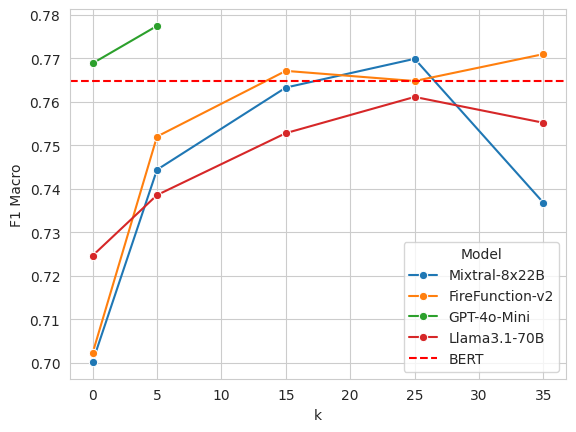

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot(data: pd.DataFrame, sampling_method: str, metric: str, baseline_value: float, baseline_name: str, 
         eval_cls: str = "overall", eval_scheme: str = "strict", save_path: str = None):

    data = data.rename(index={'Mixtral-8x22B:8x22b': 'Mixtral-8x22B', 
                                'firefunction-v2': 'FireFunction-v2', 
                                'llama3.1:70b' : 'Llama3.1-70B', 'gpt-4o-mini': 'GPT-4o-Mini'})
    data = data.xs(sampling_method, level='Sampling')
    data = data.reset_index()

    y_column = ("Value", eval_scheme, eval_cls, metric)

    sns.set_style("whitegrid")
    ax = sns.lineplot(data=data, x='k', y=y_column, hue='Model', marker='o')

    # Plot the horizontal baseline line
    baseline_line = plt.axhline(y=baseline_value, color='red', linestyle='--', label=baseline_name)

    # Customize the legend
    handles, labels = ax.get_legend_handles_labels()

    # Add the baseline handle and label if not already present
    if baseline_name not in labels:
        handles.append(baseline_line)
        labels.append(baseline_name)
    
    # Recreate the legend with the updated handles and labels
    ax.legend(handles=handles, labels=labels, title="Model")

    # Custom y-axis label
    plt.ylabel(' '.join(w.capitalize() for w in metric.split("_")))

    if save_path:
        plt.savefig(save_path)

    # Show the plot
    plt.show()


sampling_method = "rand"
metric = "f1_macro"
eval_scheme = "strict"
eval_cls = "overall"
baseline_value = get_baseline_results(baseline_output_path, eval_scheme, eval_cls, metric).mean().item()

plot(__data, sampling_method, metric, baseline_value, "BERT", save_path="../figures/results_rand_f1_macro.pdf")



/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
2024-09-10 16:53:33 matpl

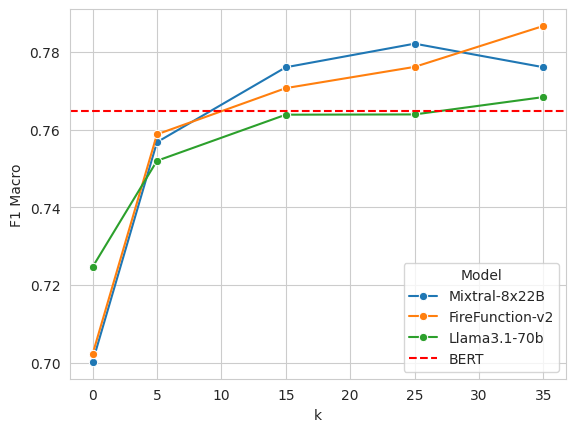

In [6]:
plot(__data, "tfidf", metric, baseline_value, "BERT", save_path="../figures/results_tfidf_f1_macro.pdf")



In [7]:
__data


Value                            \
Schema                             strict                             
Entity Type                       overall                             
Metric                           f1_macro  f1_micro precision_macro   
Model               Sampling k                                        
Mixtral-8x22B:8x22b          0   0.700174  0.703993        0.660424   
                    rand     0   0.700174  0.703993        0.660424   
                             5   0.744392  0.746455        0.712639   
                             15  0.763306  0.765177        0.728921   
                             25  0.769922  0.771394        0.734919   
                             35  0.760337  0.762558        0.731772   
                    tfidf    0   0.700174  0.703993        0.660424   
                             5   0.756760  0.759220        0.721403   
                             15  0.776048  0.778064        0.732735   
                             25  0.782126  0.784282        0.746984   
                             35  0.776056  0.778734        0.746977   
firefunction-v2              0   0.702169  0.705793        0.722857   
                    rand     0   0.702169  0.705793        0.722857   
                             5   0.752028  0.754567        0.761079   
                             15  0.767145  0.768567        0.783274   
                             25  0.764807  0.765908        0.778371   
                             35  0.771004  0.772368        0.783109   
                    tfidf    0   0.702169  0.705793        0.722857   
                             5   0.758773  0.761246        0.768487   
                             15  0.770677  0.772975        0.775953   
                             25  0.776149  0.778070        0.781329   
                             35  0.786696  0.788740        0.778736   
llama3.1:70b                 0   0.724618  0.726066        0.682858   
                    rand     0   0.724618  0.726066        0.682858   
                             5   0.738566  0.739220        0.693800   
                             15  0.752816  0.753782        0.717798   
                             25  0.761151  0.762276        0.725945   
                             35  0.755201  0.756033        0.717765   
                    tfidf    0   0.724618  0.726066        0.682858   
                             5   0.751967  0.753064        0.708747   
                             15  0.763839  0.765065        0.719780   
                             25  0.763904  0.765123        0.722844   
                             35  0.768375  0.769709        0.727647   

                                                                            \
Schema                                                                       
Entity Type                                     Artist                       
Metric                          recall_macro        f1 precision    recall   
Model               Sampling k                                               
Mixtral-8x22B:8x22b          0      0.745736  0.755328  0.715271  0.800690   
                    rand     0      0.745736  0.755328  0.715271  0.800690   
                             5      0.780353  0.782634  0.764577  0.801874   
                             15     0.802598  0.797471  0.777023  0.819667   
                             25     0.809747  0.799410  0.778097  0.822507   
                             35     0.793517  0.800967  0.795512  0.806512   
                    tfidf    0      0.745736  0.755328  0.715271  0.800690   
                             5      0.796453  0.790328  0.757586  0.826335   
                             15     0.825925  0.805948  0.766604  0.850514   
                             25     0.821376  0.812775  0.781102  0.847540   
                             35     0.807814  0.809583  0.786348  0.834279   
firefunction-v2              0      0.683287  0.734943  0.745839  0.724688   
           

In [8]:
_filtered

NameError: name '_filtered' is not defined

In [21]:
__data

Value                            \
Schema                             strict                             
Entity Type                       overall                             
Metric                           f1_macro  f1_micro precision_macro   
Model               Sampling k                                        
Mixtral-8x22B:8x22b rand     0   0.700174  0.703993        0.660424   
                             5   0.744392  0.746455        0.712639   
                             15  0.763306  0.765177        0.728921   
                             25  0.769922  0.771394        0.734919   
                    tfidf    5   0.756760  0.759220        0.721403   
                             15  0.776048  0.778064        0.732735   
                             25  0.782126  0.784282        0.746984   
firefunction-v2     rand     0   0.703034  0.706267        0.722196   
                             5   0.752028  0.754567        0.761079   
                             15  0.760406  0.761678        0.780212   
                             25  0.764807  0.765908        0.778371   
                    tfidf    5   0.758773  0.761246        0.768487   
                             15  0.770428  0.774294        0.775192   
                             25  0.776149  0.778070        0.781329   
llama3.1:70b        rand     0   0.726988  0.728105        0.681858   
                             5   0.738566  0.739220        0.693800   
                             25  0.761151  0.762276        0.725945   
                    tfidf    5   0.751967  0.753064        0.708747   
                             25  0.763904  0.765123        0.722844   

                                                                            \
Schema                                                                       
Entity Type                                     Artist                       
Metric                          recall_macro        f1 precision    recall   
Model               Sampling k                                               
Mixtral-8x22B:8x22b rand     0      0.745736  0.755328  0.715271  0.800690   
                             5      0.780353  0.782634  0.764577  0.801874   
                             15     0.802598  0.797471  0.777023  0.819667   
                             25     0.809747  0.799410  0.778097  0.822507   
                    tfidf    5      0.796453  0.790328  0.757586  0.826335   
                             15     0.825925  0.805948  0.766604  0.850514   
                             25     0.821376  0.812775  0.781102  0.847540   
firefunction-v2     rand     0      0.685041  0.736165  0.752092  0.721131   
                             5      0.743824  0.777905  0.775880  0.780395   
                             15     0.741804  0.774131  0.797097  0.752762   
                             25     0.752175  0.777896  0.786833  0.769788   
                    tfidf    5      0.749964  0.782906  0.782945  0.783378   
                             15     0.766067  0.811959  0.815812  0.808358   
                             25     0.771571  0.796028  0.791832  0.800731   
llama3.1:70b        rand     0      0.783480  0.768410  0.750805  0.787439   
                             5      0.794619  0.777437  0.763449  0.792534   
                             25     0.802561  0.787771  0.776257  0.800070   
                    tfidf    5      0.804094  0.782619  0.764431  0.802134   
                             25     0.812498  0.791820  0.772144  0.813194   

                                                                  ...  \
Schema                                                            ...   
Entity Type                                                       ...   
Metric                              missed   spurious  incorrect  ...   
Model               Sampling k                                    ...   
Mixtral-8x22B:8x22b rand     0   54.200000  96.400000  16.000000  ...   
                    

# Precision

In [5]:
_results = results_to_dataframe(results, "precision", "mean").reset_index()
_results[(_results.Schema == "strict") & (_results.k == 0)].drop(["Schema", "k"], axis=1)


TypeError: results_to_dataframe() takes from 1 to 2 positional arguments but 3 were given

# Recall

In [ ]:
_results = results_to_dataframe(results, "recall", "mean").reset_index()
_results[(_results.Schema == "strict") & (_results.k == 0)].drop(["Schema", "k"], axis=1)


,Entity Type,Model,Value
0,Artist,llama3.1,0.756232
5,Artist,llama3.1-70b,0.779171
6,WoA,llama3.1,0.716194
11,WoA,llama3.1-70b,0.775184


# F1

In [ ]:
results_to_dataframe(results, "f1_macro", "mean")


Value
Schema   Entity Type Model        k           
strict   overall     llama3.1     0   0.736789
                                  5   0.736789
                                  15  0.736789
                                  25  0.736789
                                  35  0.736789
                     llama3.1-70b 0   0.725325
exact    overall     llama3.1     0   0.751727
                                  5   0.751727
                                  15  0.751727
                                  25  0.751727
                                  35  0.751727
                     llama3.1-70b 0   0.758958
ent_type overall     llama3.1     0   0.779673
                                  5   0.779673
                                  15  0.779673
                                  25  0.779673
                                  35  0.779673
                     llama3.1-70b 0   0.768855

In [ ]:
results_to_dataframe(results, "f1", "mean")


Value
Schema   Entity Type Model        k          
strict   Artist      llama3.1-70b 0  0.771081
                     llama3.1-8b  0  0.763753
         WoA         llama3.1-70b 0  0.679570
                     llama3.1-8b  0  0.709825
exact    Artist      llama3.1-70b 0  0.833947
                     llama3.1-8b  0  0.784851
         WoA         llama3.1-70b 0  0.683969
                     llama3.1-8b  0  0.718603
ent_type Artist      llama3.1-70b 0  0.793239
                     llama3.1-8b  0  0.788424
         WoA         llama3.1-70b 0  0.744471
                     llama3.1-8b  0  0.770921